In [1]:
import numpy as np, os, sys
import pandas as pd
from scipy.io import loadmat
from scipy.signal import butter, lfilter
from scipy import stats

import heartpy as hp
import neurokit2 as nk

import matplotlib.pyplot as plt

from get_12ECG_features import get_12ECG_features_labels, detect_peaks

In [2]:
def process_signals(i, f, num_files, input_directory, df_raw):
    # print('    {}/{}...'.format(i+1, num_files))
    tmp_input_file = os.path.join(input_directory,f)
    data,header_data = load_challenge_data(tmp_input_file)
    
    features = get_HRVs_values(data, header_data)
    return features

In [3]:
def load_challenge_data(filename):

    x = loadmat(filename)
    data = np.asarray(x['val'], dtype=np.float64)

    new_file = filename.replace('.mat','.hea')
    input_header_file = os.path.join(new_file)

    with open(input_header_file,'r') as f:
        header_data=f.readlines()


    return data, header_data

In [4]:
input_directory = '../Training_WFDB'

input_files = []
for f in os.listdir(input_directory):
    if os.path.isfile(os.path.join(input_directory, f)) and not f.lower().startswith('.') and f.lower().endswith('mat'):
        input_files.append(f)
        
df_raw = pd.DataFrame()
num_files = len(input_files)

In [5]:
def get_HRVs_values(data, header_data):

    filter_lowcut = 0.001
    filter_highcut = 15.0
    filter_order = 1

    tmp_hea = header_data[0].split(' ')
    ptID = tmp_hea[0]
    num_leads = int(tmp_hea[1])
    sample_Fs= int(tmp_hea[2])
    gain_lead = np.zeros(num_leads)
    
    for ii in range(num_leads):
        tmp_hea = header_data[ii+1].split(' ')
        gain_lead[ii] = int(tmp_hea[2].split('/')[0])


    for iline in header_data:
        if iline.startswith('#Age'):
            tmp_age = iline.split(': ')[1].strip()
            age = int(tmp_age if tmp_age != 'NaN' else np.nan())
            age = int(tmp_age)
        elif iline.startswith('#Sex'):
            tmp_sex = iline.split(': ')[1]
            if tmp_sex.strip()=='Female':
                sex =1
            else:
                sex=0
        elif iline.startswith('#Dx'):
            label = iline.split(': ')[1].split(',')[0]
            #label = iline.split(': ')[1].split(',')

    signal = data[1]
    gain = gain_lead[1]

    ecg_signal = nk.ecg_clean(signal*gain, sampling_rate=sample_Fs, method="biosppy")
    _ , rpeaks = nk.ecg_peaks(ecg_signal, sampling_rate=sample_Fs)
    hrv_time = nk.hrv_time(rpeaks, sampling_rate=sample_Fs)
    
    
    peaks = rpeaks['ECG_R_Peaks']
    
    
    # print(label, age)
    print(f'Paciente {label} Edad {age}')
    print(f'Duracion de la muestra: {len(signal) / sample_Fs} s')
    
    plt.figure(figsize=(20,5))
    plt.scatter(peaks, signal[np.array(peaks)]*gain, color='r')
    plt.plot(signal*gain)
    plt.show()
    
    
    win = 2500  # 5 segundos => 5 * sample_Fs
    rr_median = np.array([])
    
    for i in range(0, len(peaks), 1):
        # Me paro en el primer peak y miro 5s hacia adelante y hacia atras
        rg = np.array(range(peaks[i] - win, peaks[i] + win, 1))
        rr = []
        
        # Recorro el vector de peaks
        for x in range(len(peaks)):
            # Me fijo si hay algun peak dentro del rango definido
            if peaks[x] in rg:
                # Si encuentro uno lo agrego
                rr.append(peaks[x])
        
        # Paso mi vector rr de samples a tiempo
        rr = np.array(rr) / (sample_Fs)
        rr_diff = np.diff(rr)
        
        # Calculo la mediana movil para los peaks detectados dentro de la ventana
        rr_window = pd.Series(rr_diff).rolling(len(rr_diff)).median()
        rr_median = np.append(rr_median, rr_window.dropna())
    
    print('Intervalos RR con filtro de mediana:')
    print(f'{rr_median} \n')
    # print(stats.tvar(np.diff(rr_median)))
    print(f'Varianza del vector RR filtrado: {stats.tvar(rr_median)}')
    
        
    hrv_time['age'] = age
    hrv_time['label'] = label
    
    return hrv_time

Paciente PAC
 Edad 64
Duracion de la muestra: 10.0 s


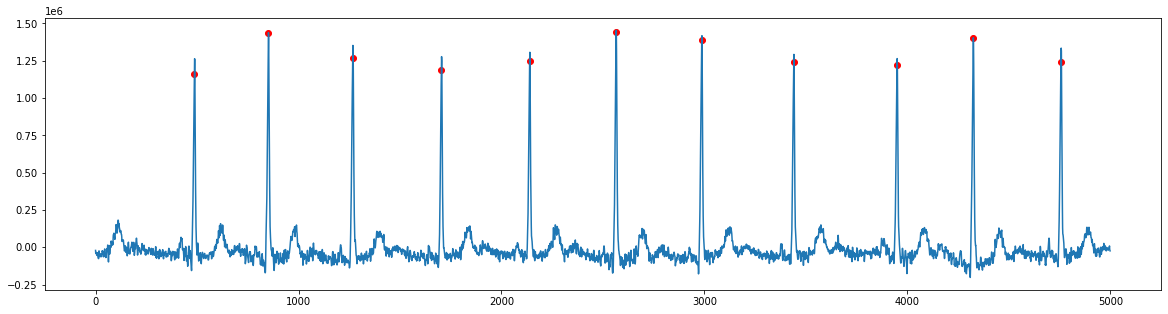

Intervalos RR con filtro de mediana:
[0.852 0.848 0.852 0.861 0.852 0.858 0.858 0.867 0.864 0.858 0.864] 

Varianza del vector RR filtrado: 3.6854545454539876e-05


Paciente Normal
 Edad 24
Duracion de la muestra: 20.0 s


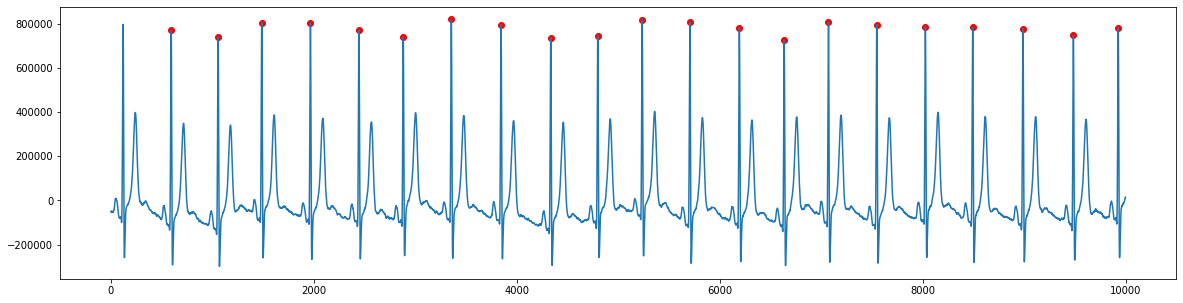

Intervalos RR con filtro de mediana:
[0.924 0.936 0.948 0.952 0.948 0.937 0.944 0.952 0.944 0.933 0.944 0.946
 0.936 0.936 0.946 0.946 0.952 0.942 0.952 0.955 0.958] 

Varianza del vector RR filtrado: 6.903333333332633e-05


Paciente PAC
 Edad 59
Duracion de la muestra: 14.224 s


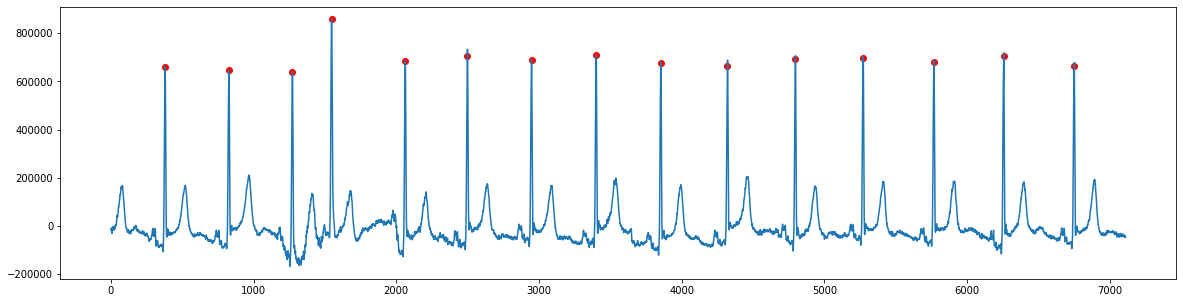

Intervalos RR con filtro de mediana:
[0.89  0.892 0.894 0.897 0.9   0.903 0.906 0.92  0.942 0.942 0.95  0.951
 0.952 0.965 0.978] 

Varianza del vector RR filtrado: 0.0008976952380952456


Paciente Normal
 Edad 14
Duracion de la muestra: 14.0 s


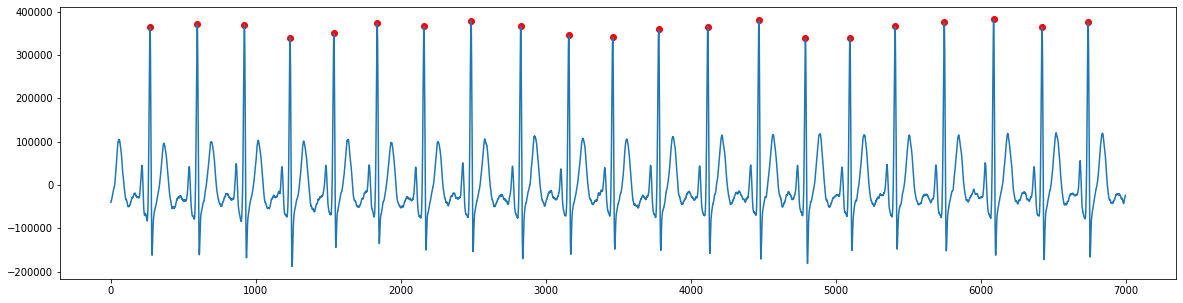

Intervalos RR con filtro de mediana:
[0.644 0.647 0.65  0.647 0.644 0.647 0.65  0.647 0.643 0.638 0.643 0.647
 0.656 0.656 0.662 0.652 0.642 0.656 0.67  0.656 0.642] 

Varianza del vector RR filtrado: 5.8661904761903215e-05


Paciente RBBB
 Edad 40
Duracion de la muestra: 11.0 s


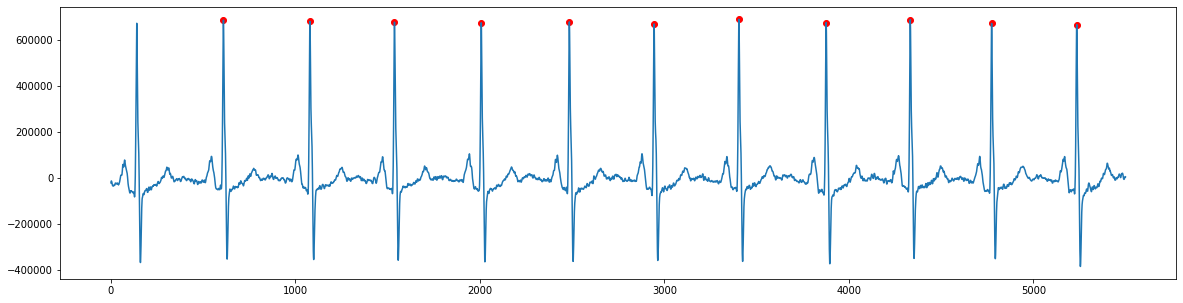

Intervalos RR con filtro de mediana:
[0.938 0.929 0.938 0.929 0.92  0.922 0.92  0.922 0.92  0.919 0.92 ] 

Varianza del vector RR filtrado: 5.236363636363548e-05


Paciente I-AVB
 Edad 64
Duracion de la muestra: 19.0 s


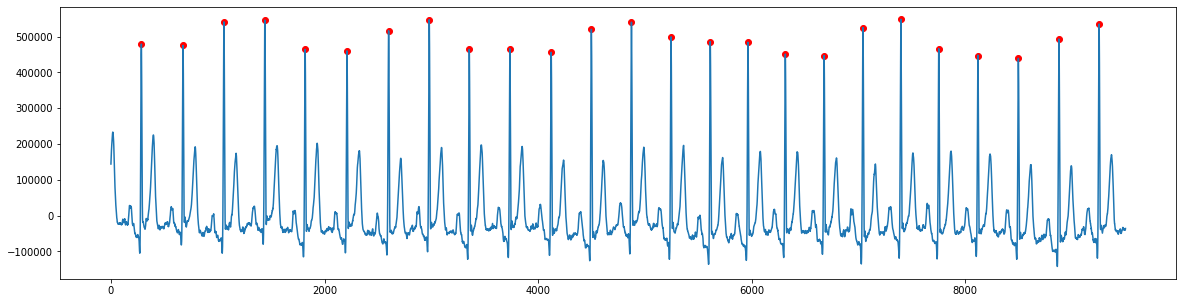

Intervalos RR con filtro de mediana:
[0.773 0.766 0.766 0.766 0.766 0.766 0.763 0.76  0.757 0.753 0.752 0.751
 0.745 0.737 0.731 0.73  0.73  0.73  0.73  0.728 0.727 0.728 0.73  0.732
 0.742] 

Varianza del vector RR filtrado: 0.00026040666666664927


Paciente AF
 Edad 56
Duracion de la muestra: 10.0 s


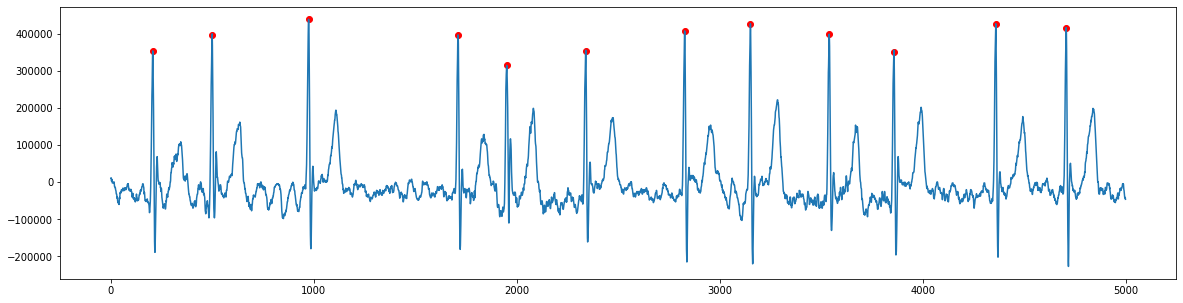

Intervalos RR con filtro de mediana:
[0.778 0.865 0.778 0.776 0.777 0.776 0.777 0.776 0.736 0.736 0.776 0.736] 

Varianza del vector RR filtrado: 0.001152628787878785


Paciente AF Edad 76
Duracion de la muestra: 10.0 s


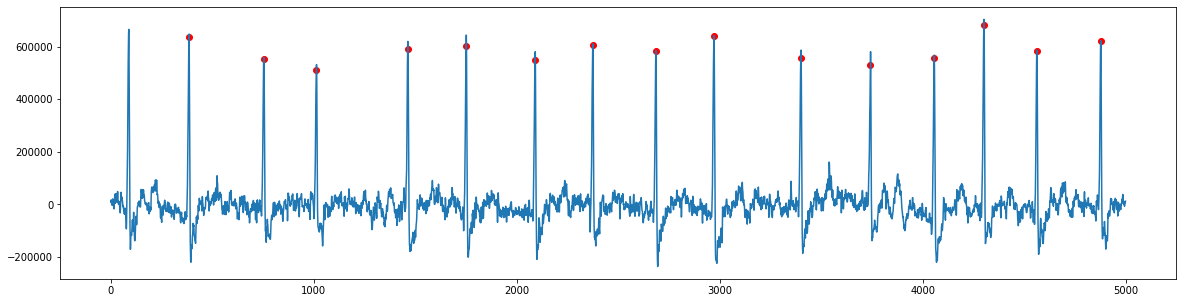

Intervalos RR con filtro de mediana:
[0.622 0.599 0.622 0.65  0.628 0.622 0.622 0.625 0.622 0.625 0.622 0.625
 0.622 0.622 0.628] 

Varianza del vector RR filtrado: 9.763809523809537e-05


Paciente RBBB Edad 89
Duracion de la muestra: 10.0 s


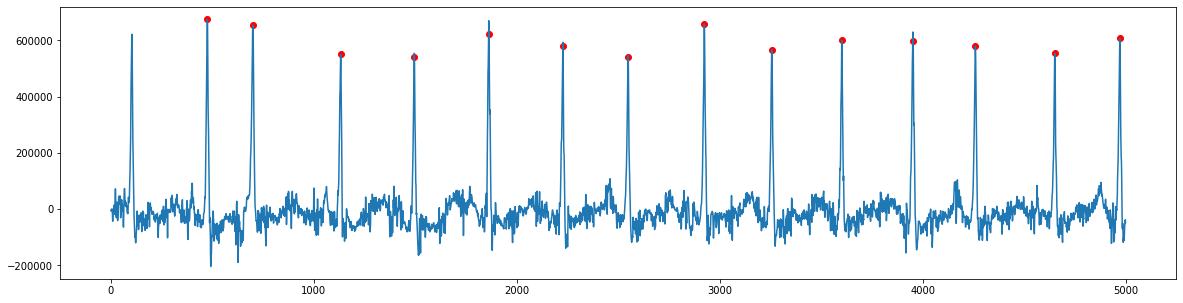

Intervalos RR con filtro de mediana:
[0.73  0.73  0.724 0.712 0.7   0.712 0.7   0.7   0.7   0.7   0.695 0.69
 0.677 0.69 ] 

Varianza del vector RR filtrado: 0.00024314285714285513


Paciente PVC
 Edad 42
Duracion de la muestra: 10.0 s


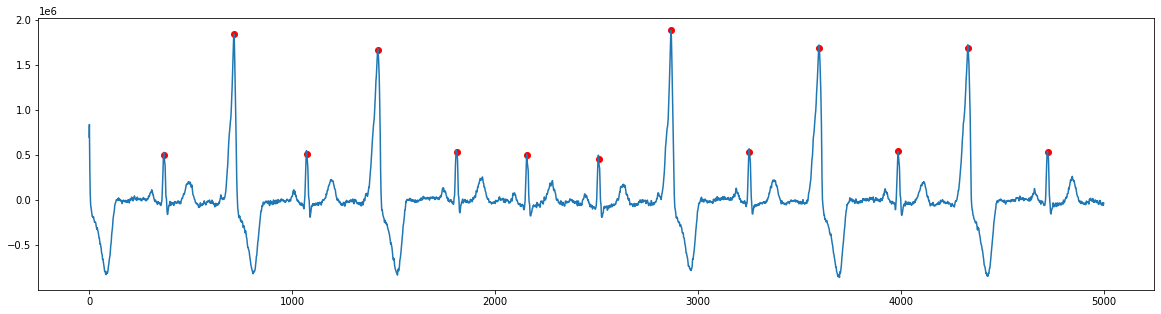

Intervalos RR con filtro de mediana:
[0.706 0.706 0.71  0.706 0.71  0.706 0.71  0.71  0.71  0.714 0.71  0.714
 0.743] 

Varianza del vector RR filtrado: 9.474358974359369e-05


Paciente AF
 Edad 80
Duracion de la muestra: 14.0 s


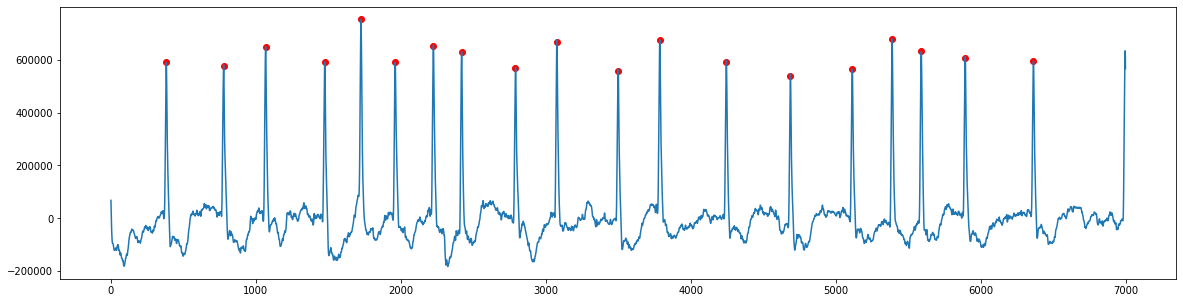

Intervalos RR con filtro de mediana:
[0.553 0.57  0.575 0.574 0.574 0.577 0.58  0.58  0.662 0.577 0.574 0.572
 0.606 0.675 0.726 0.846 0.73  0.73  0.73 ] 

Varianza del vector RR filtrado: 0.006964029239766071


Paciente PVC
 Edad 62
Duracion de la muestra: 32.436 s


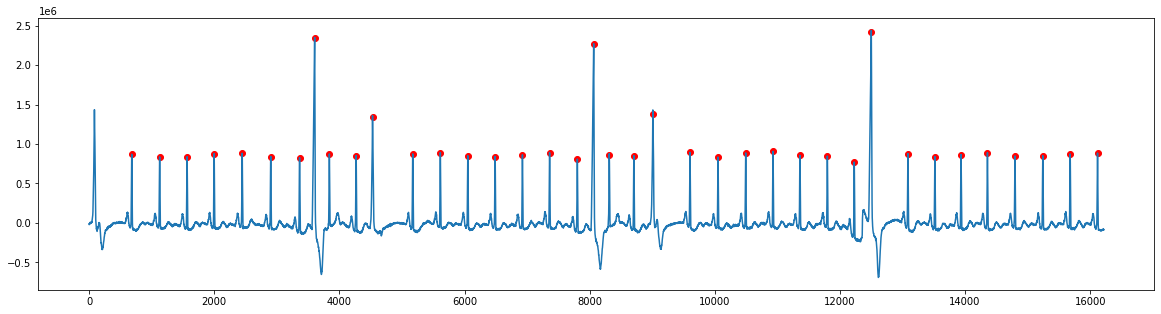

Intervalos RR con filtro de mediana:
[0.892 0.892 0.885 0.878 0.871 0.878 0.878 0.878 0.878 0.878 0.874 0.872
 0.871 0.871 0.872 0.872 0.872 0.872 0.873 0.872 0.872 0.87  0.874 0.86
 0.86  0.875 0.875 0.868 0.861 0.862 0.861 0.869 0.868 0.874 0.875 0.874
 0.875 0.876] 

Varianza del vector RR filtrado: 5.096159317210889e-05


Paciente LBBB
 Edad 76
Duracion de la muestra: 10.0 s


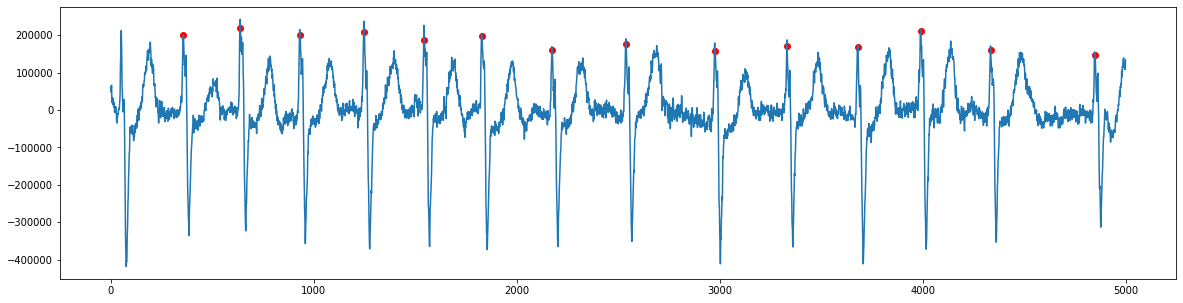

Intervalos RR con filtro de mediana:
[0.592 0.613 0.634 0.663 0.634 0.634 0.661 0.688 0.69  0.692 0.694 0.696
 0.712 0.704] 

Varianza del vector RR filtrado: 0.0014115659340659345


Paciente RBBB
 Edad 76
Duracion de la muestra: 15.0 s


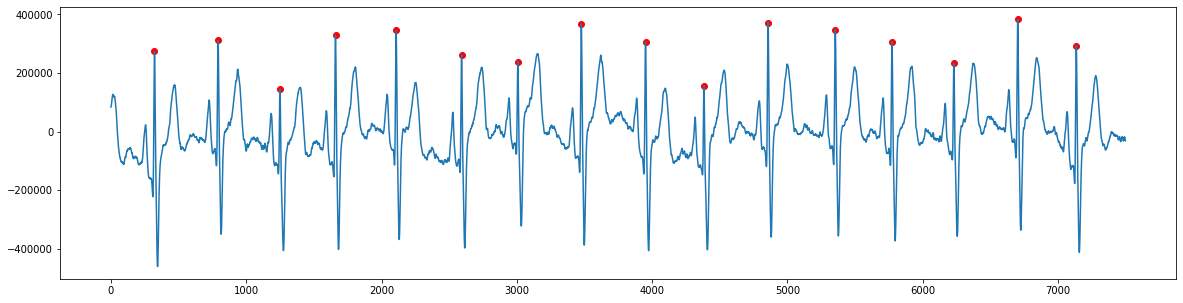

Intervalos RR con filtro de mediana:
[0.916 0.906 0.916 0.927 0.916 0.927 0.927 0.917 0.927 0.941 0.927 0.938
 0.93  0.916 0.93  0.916] 

Varianza del vector RR filtrado: 8.612916666666676e-05


Paciente I-AVB
 Edad 81
Duracion de la muestra: 10.0 s


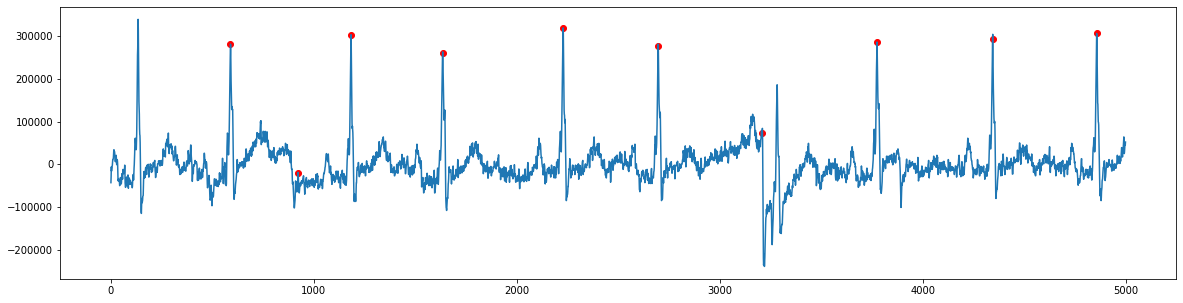

Intervalos RR con filtro de mediana:
[0.902 0.919 0.919 0.936 0.979 1.022 1.024 1.081 1.026 1.081] 

Varianza del vector RR filtrado: 0.004543211111111113




In [6]:
for i, f in enumerate(input_files[:15]):
    process_signals(i, f, num_files, input_directory, df_raw)
    print('\n')